Preparing data

In [ ]:
in_path = 'D:/Task01_BrainTumour/dicom_files/labels'
out_path = 'D:/Task02_BrainTumor/dicom_groups/labels'

In [ ]:
from glob import glob
import shutil
import os
import dicom2nifti
import nibabel as nib
import numpy as np

In [ ]:
for patient in glob(in_path + '/*'):
    patient_name = os.path.basename(os.path.normpath(patient))
    number_folders = int(len(glob(patient+'/*'))/64)
    for i in range(number_folders):
        output_path_name = os.path.join(out_path, patient_name + '_' + str(i))
        os.mkdir(output_path_name)
        for i, file in enumerate(glob(in_path+'/*')):
            if i == 64 + 1:
                break
            shutil.move(file, output_path_name)

In [ ]:
in_path_images = 'D:/Task01_BrainTumour/dicom_groups/images/*'
in_path_labels = 'D:/Task01_BrainTumour/dicom_groups/labels/*'
out_path_images = 'D:/Task01_BrainTumour/nifti_files/images/*'
out_path_labels = 'D:/Task01_BrainTumour/nifti_files/labels/*'

list_images = sorted(glob(in_path_images))
list_labels = sorted(glob(in_path_labels))

In [ ]:
for patient in list_images:
    patient_name = os.path.basename(os.path.normpath(patient))
    dicom2nifti.dicom_series_to_nifti(patient, os.path.join(out_path_images, patient_name + '.nii.gz'))

for patient in list_labels:
    patient_name = os.path.basename(os.path.normpath(patient))
    dicom2nifti.dicom_series_to_nifti(patient, os.path.join(out_path_labels, patient_name + '.nii.gz'))

In [ ]:
input_nifti_file_path = 'D:/Task01_BrainTumour/Final/TestLabels/*'
list_labels = sorted(glob(input_nifti_file_path))

for patient in list_labels:
    nifti_file = nib.load(patient)
    fdata = nifti_file.get_fdata()
    np_unique = np.unique(fdata)
    if len(np_unique) >1:
        print(patient)

Preprocessing data

In [4]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


True
NVIDIA GeForce RTX 3050 Ti Laptop GPU
[]


In [5]:
import os 
from glob import glob
import shutil
from tqdm import tqdm
import dicom2nifti
import numpy as np
import nibabel as nib
from monai.transforms import (
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    BorderPadd,
    Lambdad,
    Transform,

)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
from monai.utils import first
import matplotlib.pyplot as plt

In [1]:
def prepare(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=0, a_max=1000, spatial_size=[128, 128, 128], cache=False):
    set_determinism(seed=0)

    path_train_images = sorted(glob(os.path.join(in_dir, "TrainImages", "*.nii.gz")))
    path_train_labels = sorted(glob(os.path.join(in_dir, "TrainLabels", "*.nii.gz")))

    path_test_images = sorted(glob(os.path.join(in_dir, "TestImages", "*.nii.gz")))
    path_test_labels = sorted(glob(os.path.join(in_dir, "TestLabels", "*.nii.gz")))

    train_files = [{"image": img, "label": lbl} for img, lbl in zip(path_train_images, path_train_labels)]
    test_files = [{"image": img, "label": lbl} for img, lbl in zip(path_test_images, path_test_labels)]

    train_transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstD(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=pixdim, mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # BorderPadd(keys=["image", "label"], spatial_border=(4, 4, 4), mode="constant"),
        Resized(keys=["image", "label"], spatial_size=spatial_size),
        Lambdad(keys=["image"], func=lambda x: torch.mean(x, dim=0, keepdim=True)), 
        ToTensord(keys=["image", "label"]),  
])

    test_transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstD(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=pixdim, mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # BorderPadd(keys=["image", "label"], spatial_border=(4, 4, 4), mode="constant"),
        Resized(keys=["image", "label"], spatial_size=spatial_size),
        Lambdad(keys=["image"], func=lambda x: torch.mean(x, dim=0, keepdim=True)), 
        ToTensord(keys=["image", "label"]),
    ])

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        test_ds = Dataset(data=test_files, transform=test_transforms)

    train_loader = DataLoader(train_ds, batch_size=10)
    test_loader = DataLoader(test_ds, batch_size=10)

    return train_loader, test_loader

Useful Functions

In [7]:
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm

def dice_metric(predicted, target):
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count / summ
    weights = 1 / weights
    summ = weights.sum()
    weights = weights / summ
    return torch.tensor(weights, dtype=torch.float32)

def train(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1, device=torch.device("cuda:0")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    train_loader, test_loader = data_in

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0

        for batch_data in train_loader:
            train_step += 1

            volume = batch_data["image"].to(device)
            label = batch_data["label"].to(device)
            label = label != 0

            optim.zero_grad()
            outputs = model(volume)
            train_loss = loss(outputs, label)
            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(
                f"{train_step}, "
                f"Train_loss: {train_loss.item():.4f}")
            
            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)       
        train_epoch_loss /= train_step
        print(f"Epoch Loss: {train_epoch_loss:.4f}")
        
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % test_interval == 0:
            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                test_step = 0
                epoch_metric_test = 0

                for test_data in test_loader:

                    test_step += 1

                    test_volume = test_data["image"]
                    test_label = test_data["label"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)

                    test_outputs = model(test_volume)

                    test_loss = loss(test_outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric

                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(model_dir, "best_metric_model.pth"))

                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

    print(f"Training completed, Best Metric: {best_metric:.4f} at Epoch {best_metric_epoch}")



def show_patient(data, SLICE_NUMBER=1, train=True, test=False):


    check_patient_train, check_patient_test = data

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)

    
    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"image {SLICE_NUMBER}")
        plt.imshow(view_train_patient["image"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"label {SLICE_NUMBER}")
        plt.imshow(view_train_patient["label"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
    
    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"image {SLICE_NUMBER}")
        plt.imshow(view_test_patient["image"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"label {SLICE_NUMBER}")
        plt.imshow(view_test_patient["label"][0, 0, :, :, SLICE_NUMBER])
        plt.show()


def calculate_pixels(data):
    val = np.zeros((1, 2))

    for batch in tqdm(data):
        batch_label = batch["label"] != 0
        _, count = np.unique(batch_label, return_counts=True)

        if len(count) == 1:
            count = np.append(count, 0)
        val += count

    print('The last values:', val)
    return val

Preprocessed Data

c:\Users\shlok\anaconda3\envs\Project\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


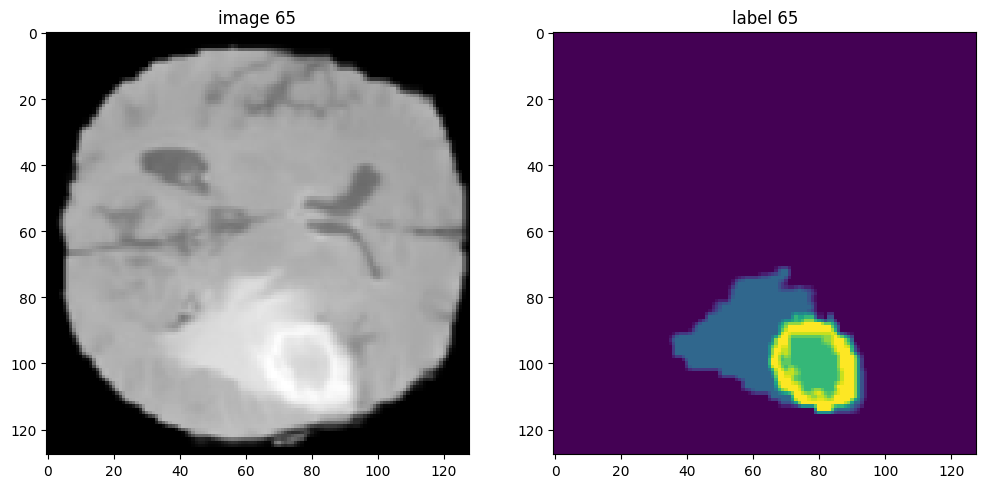

In [8]:
in_dir = 'D:/Task01_BrainTumour/Final'
patient = prepare(in_dir)
show_patient(patient,65)

Training

In [ ]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

import torch


data_dir = 'D:/Task01_BrainTumour/Final'
model_dir = 'D:/Task01_BrainTumour/Results'
data_in = prepare(data_dir)

device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,  
    out_channels=2,  
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
#loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

if __name__ == "__main__":
    train(model, data_in, loss_function, optimizer, 50, model_dir)

Testing

In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

In [ ]:
data_dir = 'D:/Task01_BrainTumour/Final'
model_dir = 'D:/Task01_BrainTumour/Results'

In [ ]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

In [ ]:
plt.figure("Results 24 November", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

In [ ]:
path_train_images = sorted(glob(os.path.join(in_dir, "TrainImages", "*.nii.gz")))
path_train_labels = sorted(glob(os.path.join(in_dir, "TrainLabels", "*.nii.gz")))

path_test_images = sorted(glob(os.path.join(in_dir, "TestImages", "*.nii.gz")))
path_test_labels = sorted(glob(os.path.join(in_dir, "TestLabels", "*.nii.gz")))

train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(path_train_images, path_train_labels)]
test_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(path_test_images, path_test_labels)]
train_files = train_files[0:9]
test_files = test_files[0:9]

In [ ]:
train_transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstD(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1000, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # BorderPadd(keys=["image", "label"], spatial_border=(4,4,4), mode="constant"),
        Resized(keys=["image", "label"], spatial_size=[128,128,128]),
        Lambdad(keys=["image"], func=lambda x: torch.mean(x, dim=0, keepdim=True)),
        ToTensord(keys=["image", "label"]),
    ])

test_transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstD(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1000, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # BorderPadd(keys=["image", "label"], spatial_border=(4,4,4), mode="constant"),
        Resized(keys=["image", "label"], spatial_size=[128,128,128]),
        Lambdad(keys=["image"], func=lambda x: torch.mean(x, dim=0, keepdim=True)),
        ToTensord(keys=["image", "label"]),
    ])

In [ ]:
train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=10)

test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=10)

In [ ]:
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,  
    out_channels=2,  
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

Output

In [ ]:
sw_batch_size = 5
roi_size = (128, 128, 128)
with torch.no_grad():
    # train_patient = first(train_loader)
    # t_volume = train_patient['image']
    # t_segmentation = train_patient['label']

    test_patient = first(test_loader)
    t_volume = test_patient['image']
    t_segmentation = test_patient['label']
    
    # train_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    # sigmoid_activation = Activations(sigmoid=True)
    # train_outputs = sigmoid_activation(train_outputs)
    # train_outputs = train_outputs > 0.53

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.70
        
    for i in range(128):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        # plt.imshow(train_patient["image"][0, 0, :, :, i], cmap="gray")
        plt.imshow(test_patient["image"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        # plt.imshow(train_patient["label"][0, 0, :, :, i] != 0)
        plt.imshow(test_patient["label"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        # plt.imshow(train_outputs.detach().cpu()[0, 1, :, :, i])
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()